In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ds_toolbox.modelling.time_series_utils as ts
import ds_toolbox.modelling.misc_utils as ds
from ds_toolbox.visualisation import corrplot, bokeh_chart, bokeh_candlestick, plot_colors

from bokeh.plotting import show, output_notebook
output_notebook()

pd.set_option("display.max_columns", None)

Loading BokehJS ...

In [109]:
# n.b there are multiple for Biden and Trump per poll entries per poll
# e.g. pollid 57697 71780

# this is for older pre-primary polling where there was multiple candidates so multiple questions
# safe to ignore these issues for recent polls

In [14]:
raw = pd.read_csv("data/presidential_polls_2020_538_Oct28_update.csv")

raw.created_at = pd.to_datetime(raw.created_at)
raw = raw[raw.answer.isin(["Biden", "Trump"])]

# keep only state-level polls
raw = raw[raw.state.notna()]

# keep only answers from likely voters (population and population_full are always equal)
raw = raw[raw.population == "lv"]

In [15]:
states = raw.state.unique()

In [16]:
# raw["pct_biden"] = raw[raw.answer == "Biden"].pct
# raw["pct_trump"] = raw[raw.answer == "Trump"].pct

# small = raw[["poll_id", "state","created_at", "answer", "pct",]]

In [17]:
# dem = raw[(raw.state == "Ohio") & (raw.answer == "Biden")].set_index("poll_id")[["created_at", "pct"]]
# rep = raw[(raw.state == "Ohio") & (raw.answer == "Trump")].set_index("poll_id")[["created_at", "pct"]]

In [18]:
# raw[raw.state == "Ohio"].sort_values(by="created_at", ascending=False).head(50)

In [19]:
# # check there are no duplicate time-stamps in states

# for state in states:
#     state_df = raw[raw.state == state].drop_duplicates("poll_id")
#     print(state, state_df.created_at.duplicated().sum())

## Plot battleground states polling

In [20]:
wide = raw.pivot_table(index="created_at", columns=["state", "answer"], values="pct")

In [21]:
battlegrounds = ['Arizona',
 'Colorado',
 'Florida',
 'Georgia',
 'Iowa',
 'Maine',
 'Michigan',
 'Minnesota',
 'Nevada',
 'New Hampshire',
 'New Mexico',
 'North Carolina',
 'Ohio',
 'Pennsylvania',
 'Texas',
 'Virginia',
 'Wisconsin']

party_colors = ["red", "dodgerblue"]

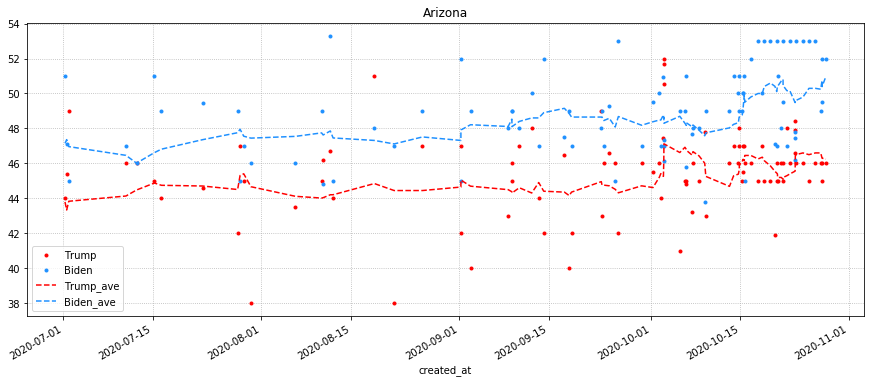

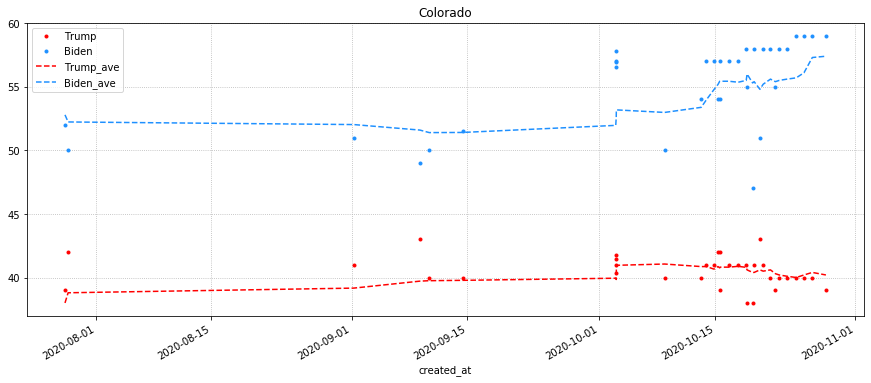

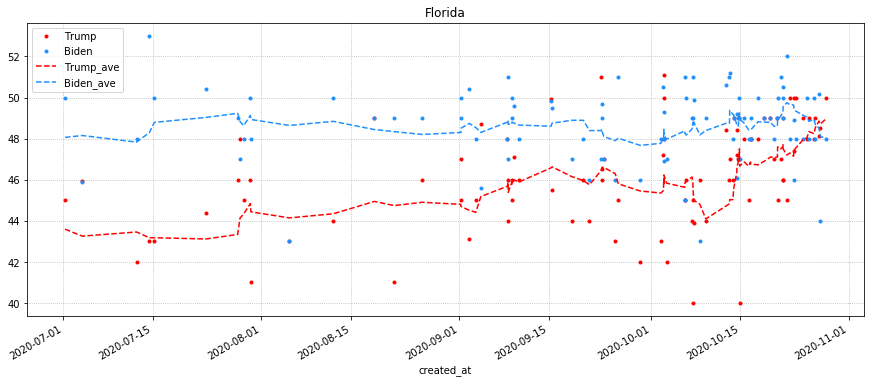

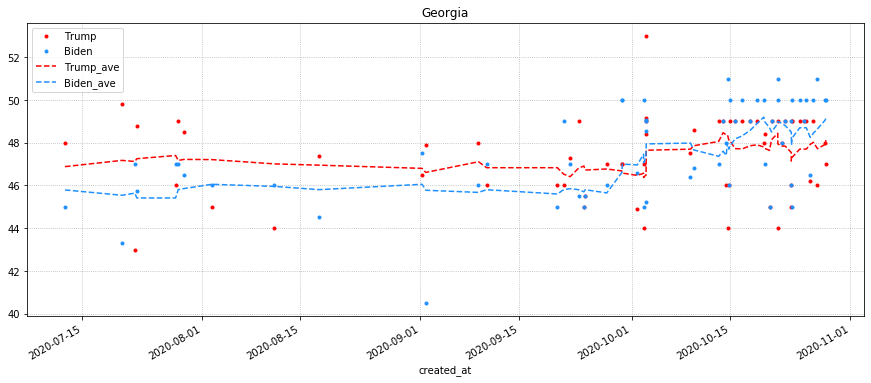

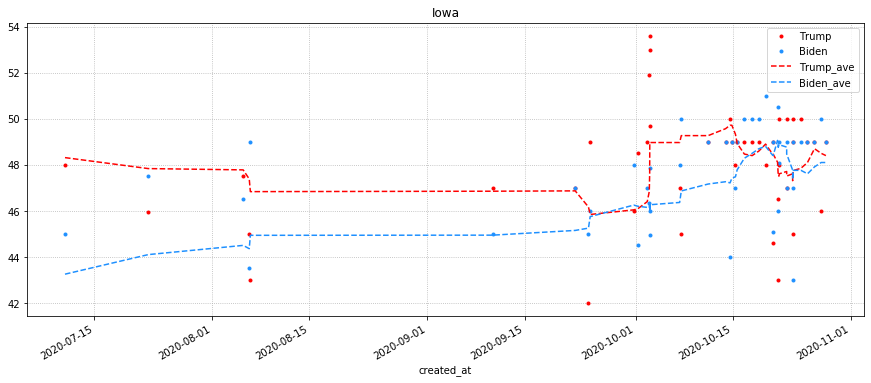

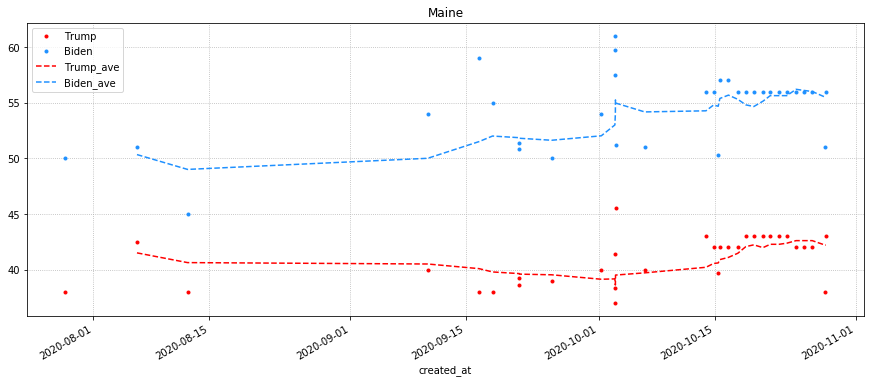

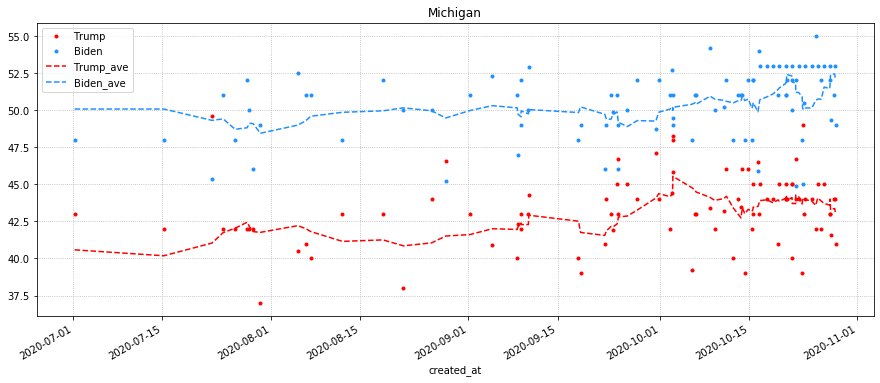

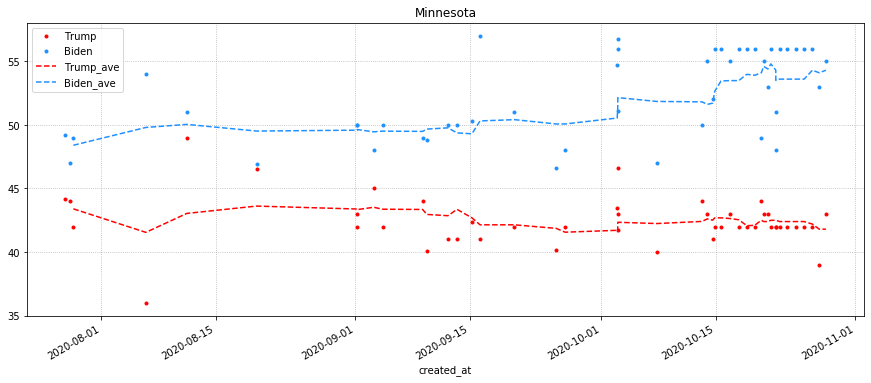

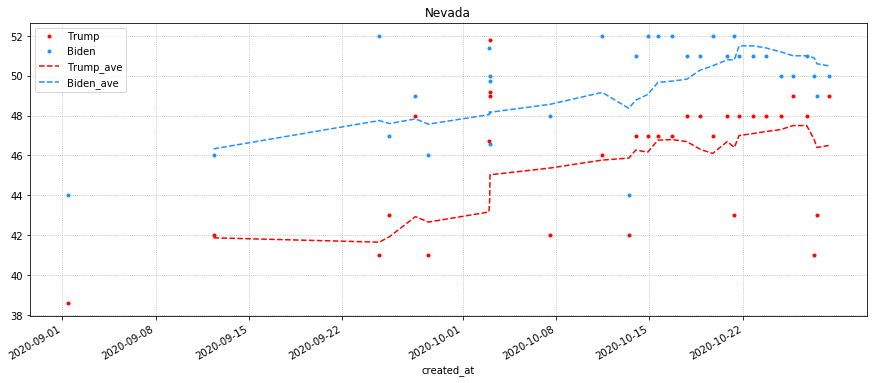

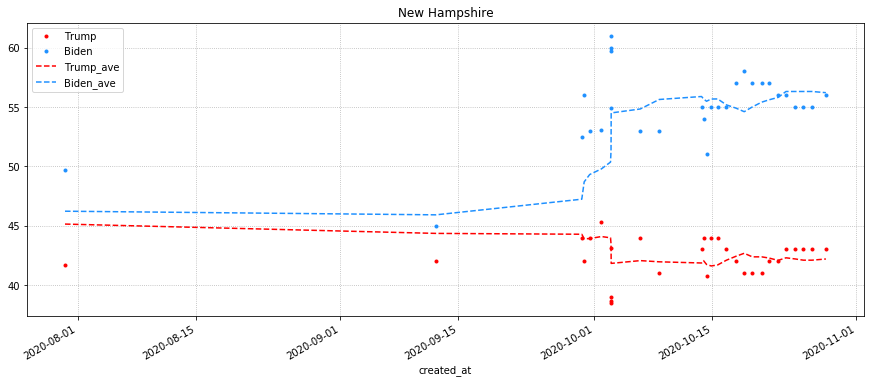

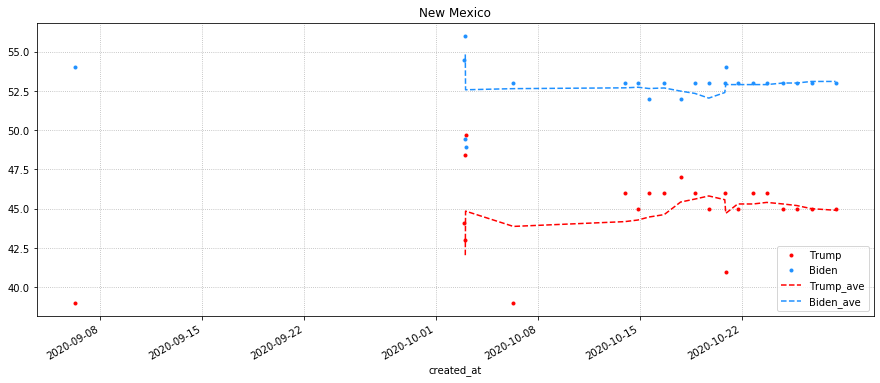

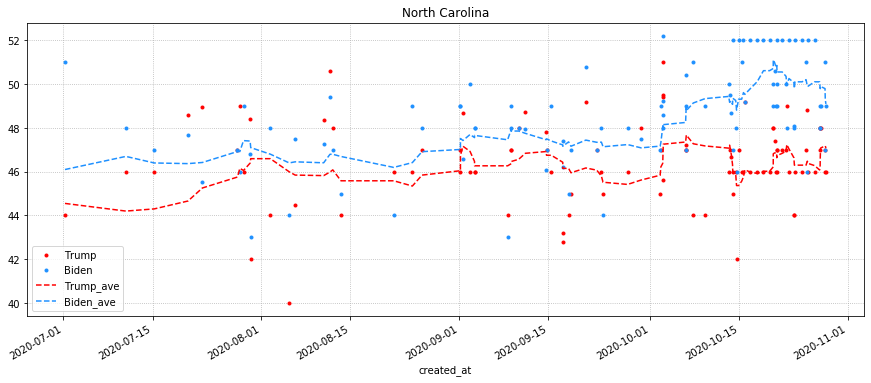

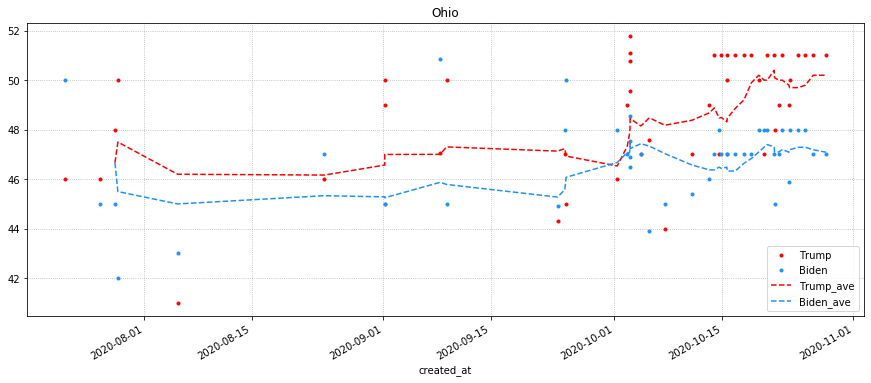

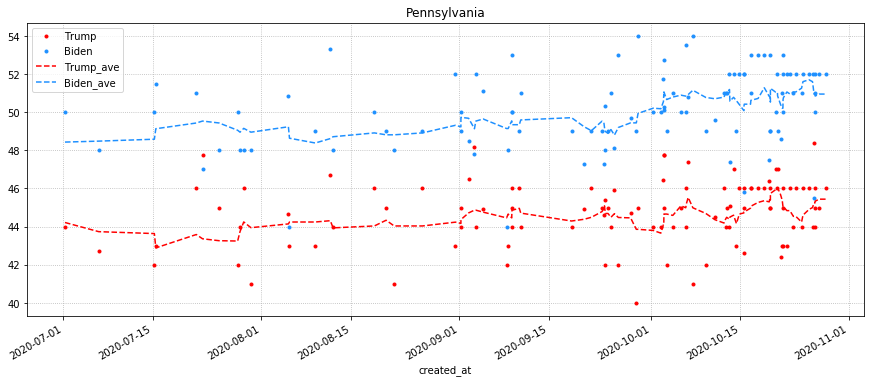

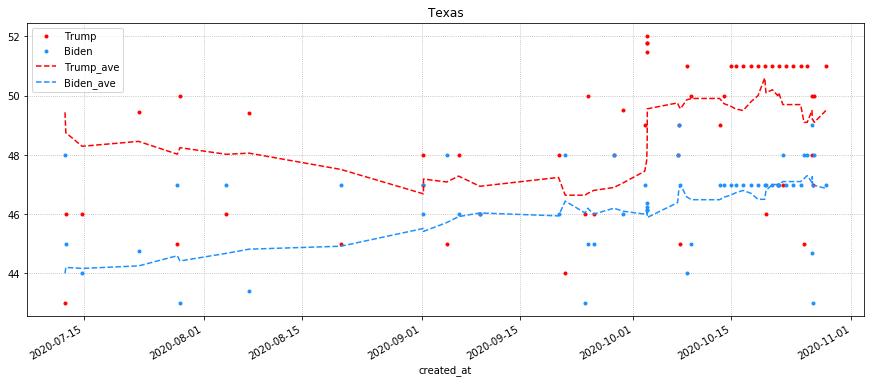

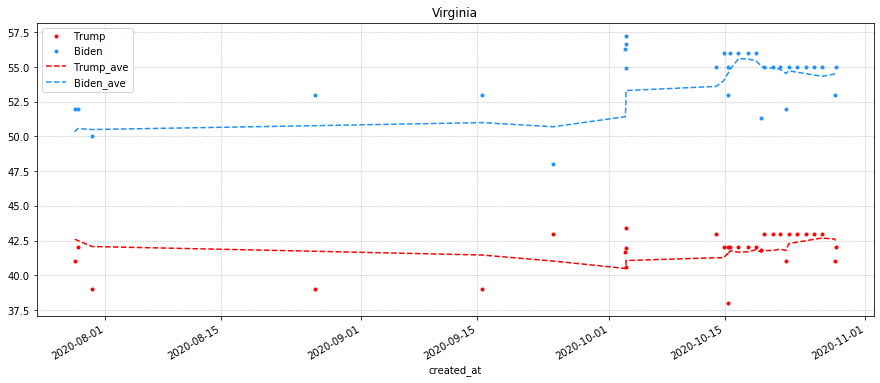

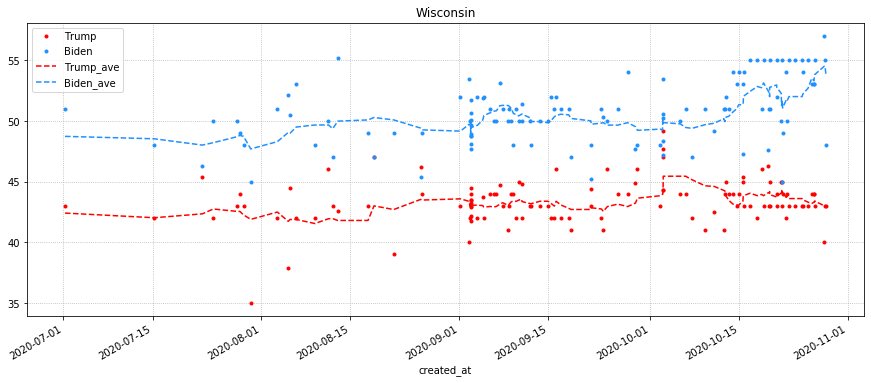

In [23]:
for state in battlegrounds:
    plot_df = wide[state].dropna()[["Trump", "Biden"]]
    plot_df_roll = plot_df.rolling(window=10, min_periods=3).mean()
    plot_df_roll.columns = ["Trump_ave", "Biden_ave"]
    plot_df = plot_df.merge(plot_df_roll, left_index=True, right_index=True, how="left")
    ts.plot(plot_df, style=[".", ".", "--", "--"], start_date="2020-07", color=2*party_colors)
    plt.title(state);


## Include margin for error

In [24]:
def plot_polling_with_errors(state, polling_error):
    start_date = "2020-07"
    plot_df = wide[state].dropna()[["Trump", "Biden"]]
    
    # calculate rolling ave of last 10 polls
    plot_df_roll = plot_df.rolling(window=10, min_periods=3).mean()
    plot_df_roll.columns = ["Trump_ave", "Biden_ave"]
    plot_df = plot_df.merge(plot_df_roll, left_index=True, right_index=True, how="left")
    plot_df.to_csv(f"data/processed/2020_polls/{state}.csv")

    ts.plot(plot_df, style=[".", ".", "--", "--"], color=2*party_colors)

    lower_blue = plot_df_roll.Biden_ave - polling_error
    upper_blue = plot_df_roll.Biden_ave + polling_error
    lower_red = plot_df_roll.Trump_ave - polling_error
    upper_red = plot_df_roll.Trump_ave + polling_error

    plt.fill_between(plot_df.index, lower_blue, upper_blue, facecolor='dodgerblue', interpolate=True, alpha=0.2)
    plt.fill_between(plot_df.index, lower_red, upper_red, facecolor='red', interpolate=True, alpha=0.2)

    plt.xlim((start_date, plot_df.index[-1]))

    plt.title(state);  

### Conservative error 3.4% each way

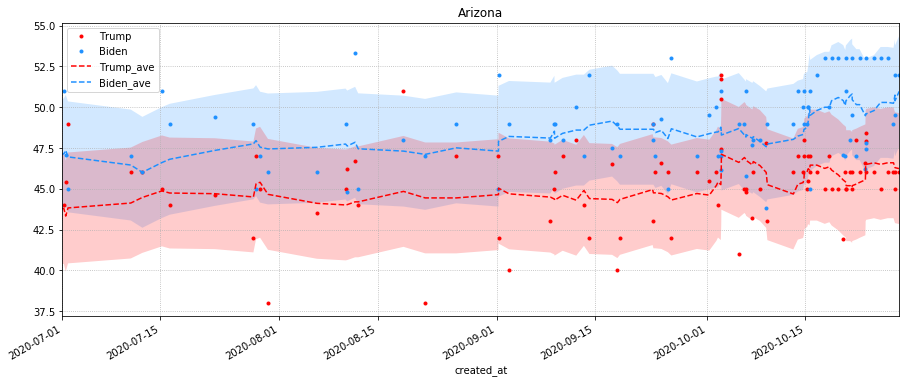

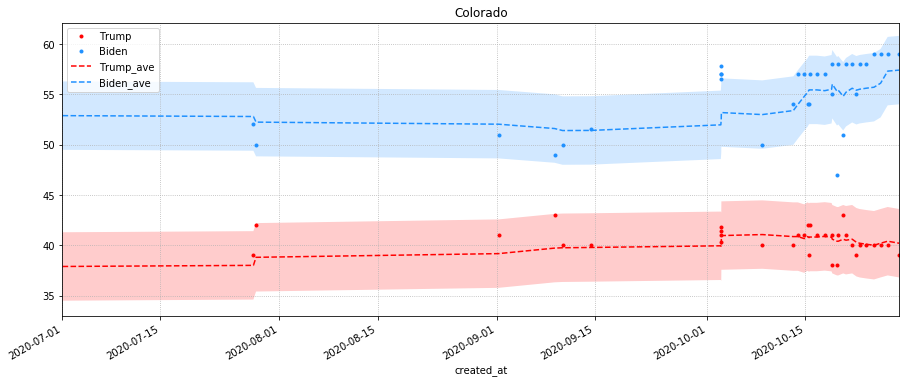

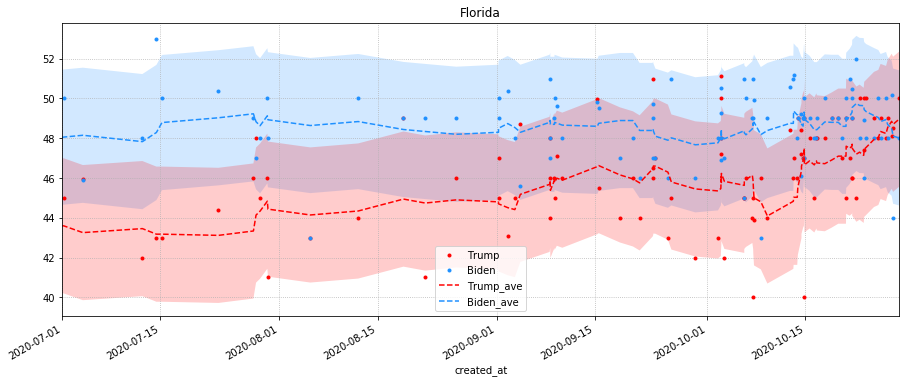

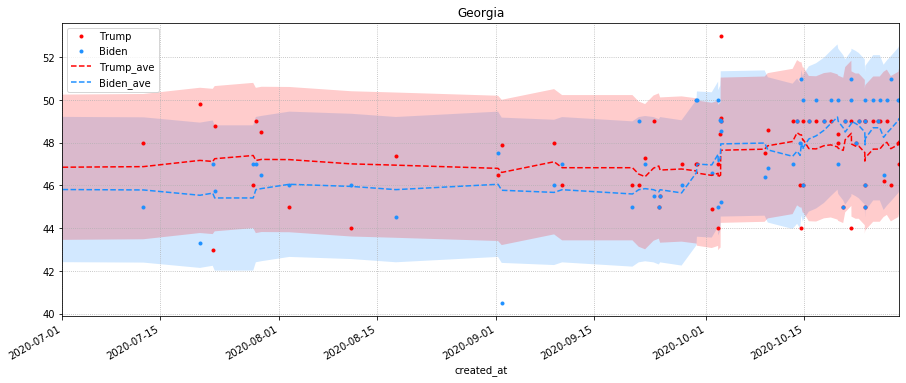

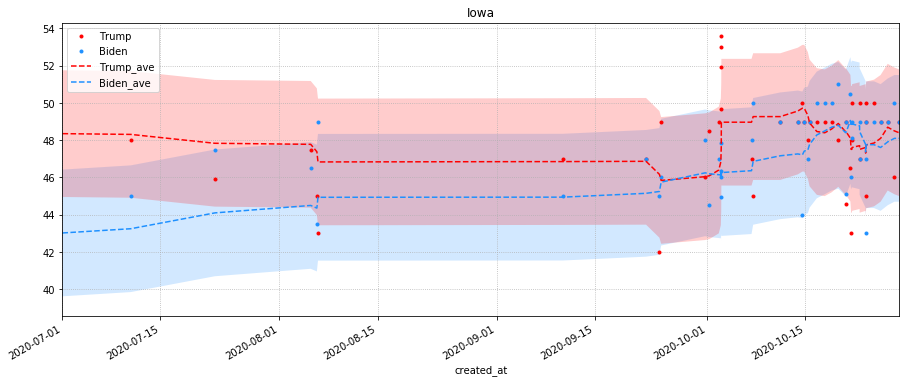

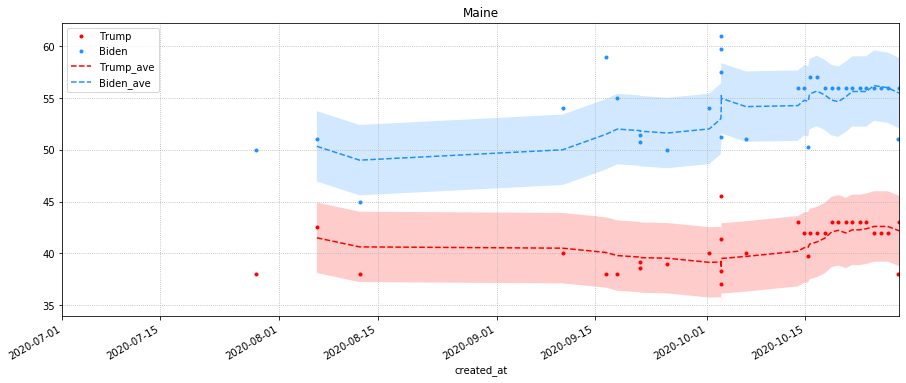

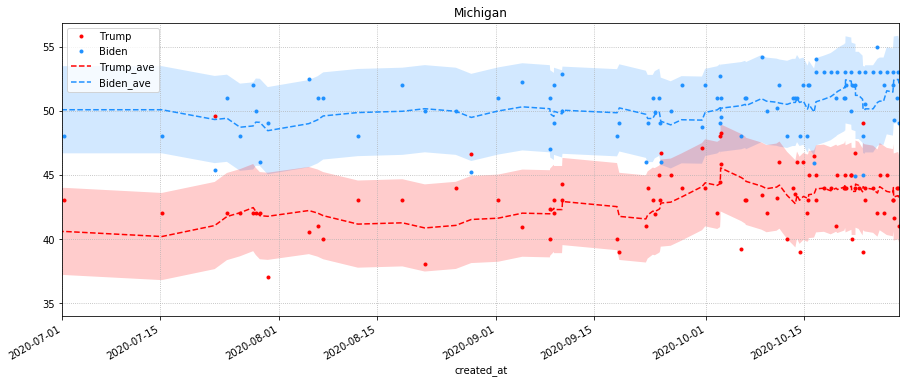

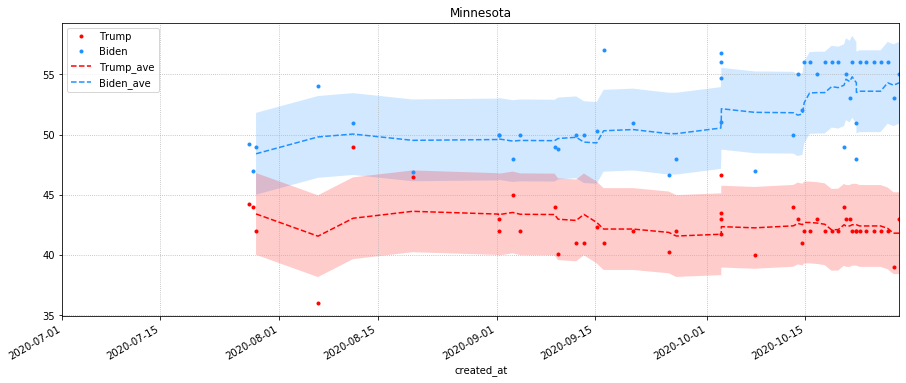

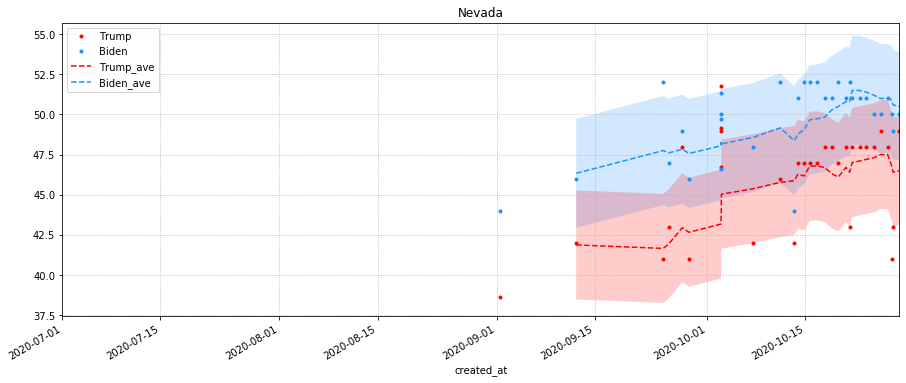

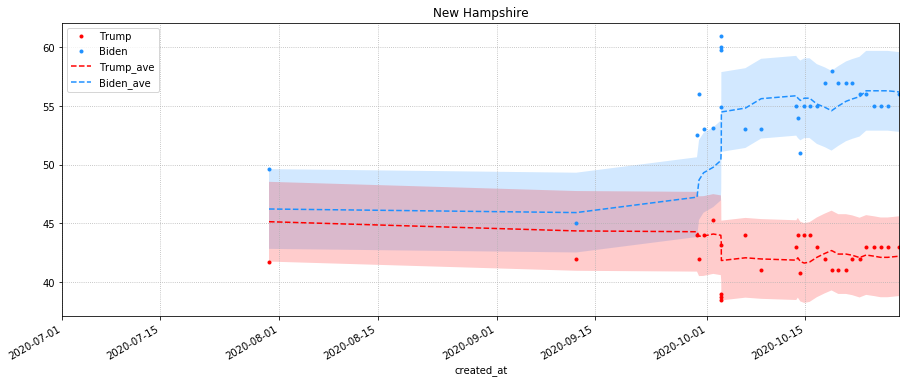

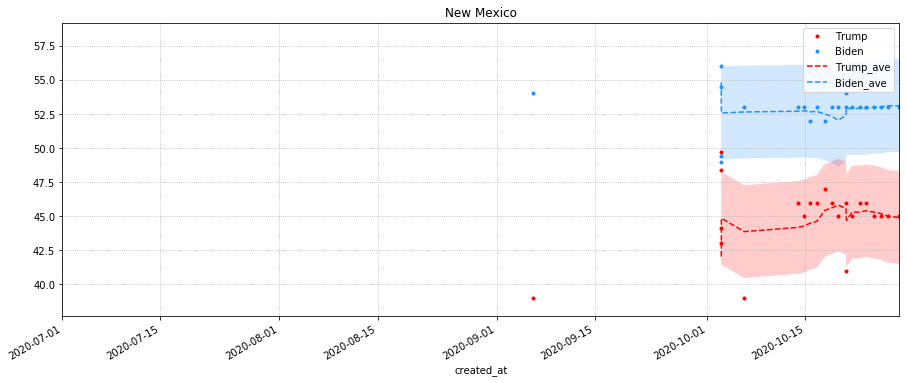

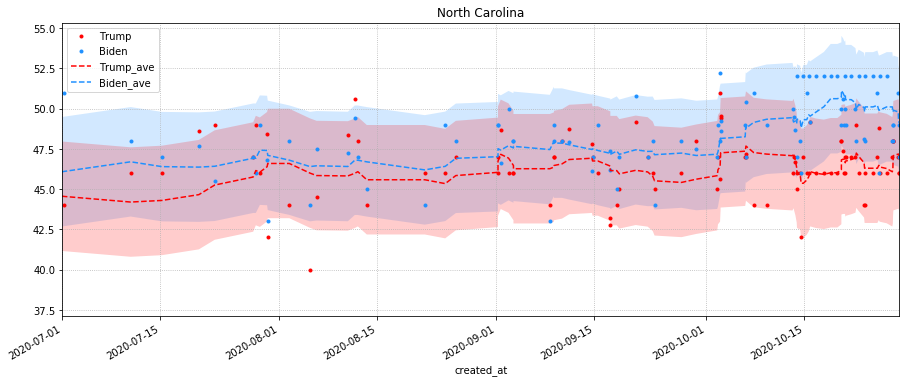

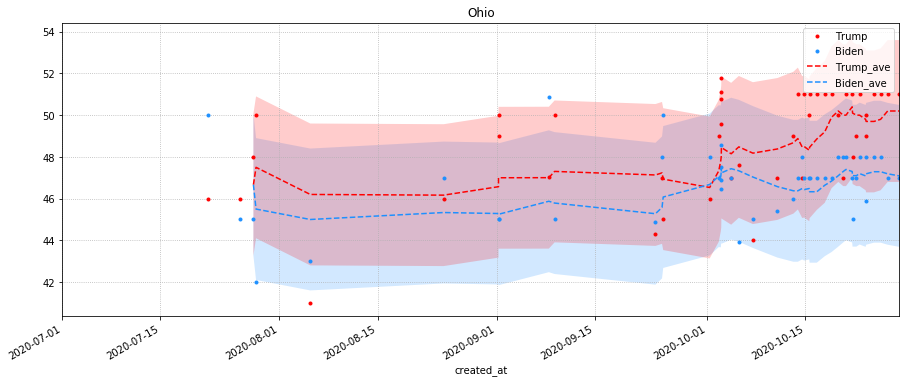

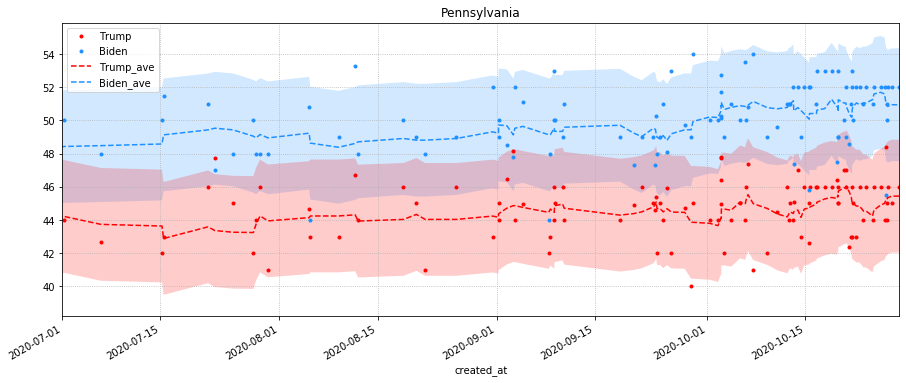

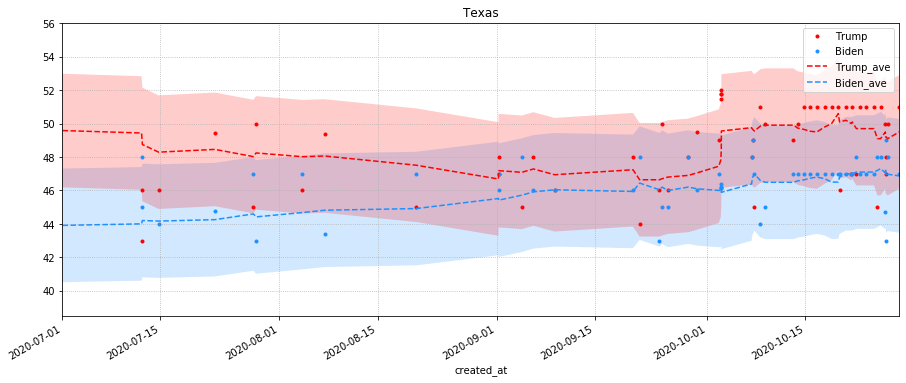

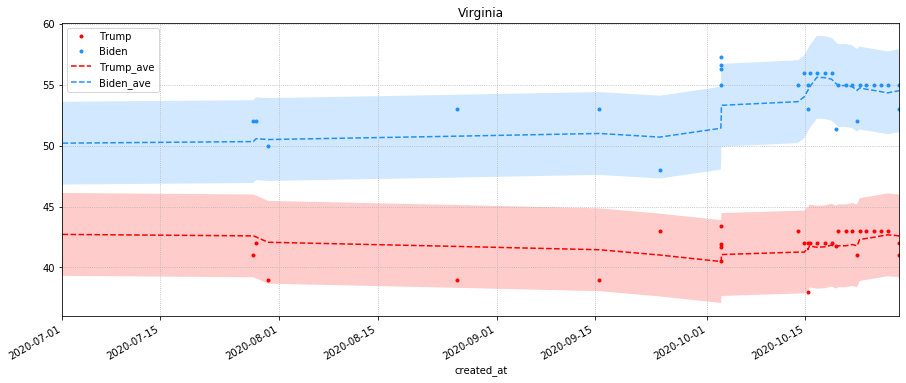

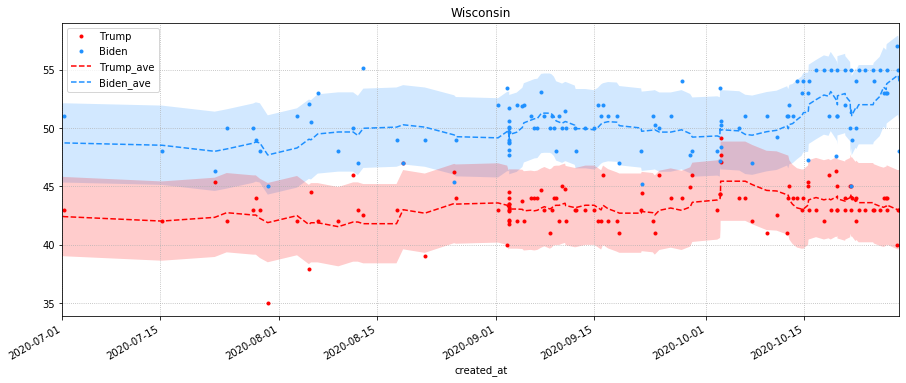

In [25]:
for state in battlegrounds:
    plot_polling_with_errors(state=state, polling_error=3.4)